# __Active Learning using Electostatic Potentials Similarity (ESPsim) as the Oracle__

## ESPsim uses 3D-similarity to find molecules with similar shape and pharmacophoric features to the query molecule

### Notes
The notebook is similar to the 23_Active_learning_regression notebook with a chnage to the oracle

## Pat Walters notes
Some of the code and data in this notebook was borrowed from other open source projects. 

- The query and database molecules were taken from the [LitPCBA](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00155) set. 

- The 3D overlay code came from [ESPSim](https://github.com/hesther/espsim)

- Some code was also borrowed from [Lig3DLens](https://github.com/healx/lig3dlens)  

Many thanks to the authors of these packages for their commitment to open science. 

## Requirments for the notebook

!pip install 'modAL-python>=0.4.1 useful-rdkit-utils loguru py3Dmol

!pip install git+https://github.com/hesther/espsim.git@533a53105858d1a25cbe2fb54dd7208d7989caa1


In [4]:
import os
import requests

# Download scripts from the Lig3DLens github repository and data from the Practical Cheminformatics Tutorials repository
url_list = ["https://github.com/healx/lig3dlens/raw/main/lig3dlens/align3D_score.py",
            "https://github.com/healx/lig3dlens/raw/main/lig3dlens/gen_conformers.py",
            "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/active_learning/data/2chw_lig.sdf",
            "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/active_learning/data/MAPK1.csv"]
file_name = ["align3D_score.py", 
             "gen_conformers.py",
             "data/2chw_lig.sdf",
             "data/MAPK1.csv"]

os.makedirs("./data", exist_ok=True)

for url, name in zip(url_list, file_name):
    r = requests.get(url)
    with open(name, 'wb') as f:
        f.write(r.content)

In [5]:
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.gaussian_process as gp
import useful_rdkit_utils as uru
from modAL.acquisition import BaseLearner
from modAL.models import BayesianOptimizer
from modAL.utils.data import modALinput
from modAL.acquisition import optimizer_PI
from rdkit import Chem
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm.auto import tqdm
from modAL.utils.selection import multi_argmax
from align3D_score import score_alignment
from gen_conformers import generate_conformers
import py3Dmol

# Enable progress bar
tqdm.pandas(desc="Progress")

## Defining Functions

Functions to be defined:

1. Oracle - Using ESPsim 

2. Kernel function for the Gaussian Process Regression

3. Untility functions:

    - find_best_index: Sort the predicted scores, remove the previously selected molecules and return the top compounds that have not been used

    - compile_results: Compiles the results from the shape search with the corresponding molecules

4. Acquisition function:

    - greedy query_strategy

    - Maximum Probability of Imporvement query_strategy

In [64]:
class ESPsimOracle:
    """
    A class representing an oracle for ESPsim active learning.

    Attributes:
        ref_molfile (str): The path to the reference molecule file.

    Methods:
        __init__(self, ref_molfile): Initializes the ESPsimOracle object.
        get_values(self, input_smiles_list): Returns a list of alignment scores for the given input SMILES list.
    """

    def __init__(self, ref_molfile):
        """
        Initializes the ESPsimOracle object.

        Args:
            ref_molfile (str): The path to the reference molecule file. Prepares the reference molecule for 3D generation.
        """
        self.ref_mol = Chem.MolFromMolFile(ref_molfile)
        self.ref_mol = Chem.AddHs(self.ref_mol)

    def get_values(self, input_smiles_list):
        """
        Returns a list of alignment scores for the given input SMILES list.

        Args:
            input_smiles_list (list): A list of SMILES strings representing molecules.

        Returns:
            list: A list of alignment scores for the input molecules.

        """
        result_list = []
        for smi in tqdm(input_smiles_list):
            result = None
            mol = Chem.MolFromSmiles(smi)
            if mol:
                mol = Chem.AddHs(mol)
                mol_3d = generate_conformers(mol, 25)
                if mol_3d:
                    result = score_alignment(mol_3d, self.ref_mol)
            result_list.append(result)
        return result_list
    

def calculate_similarity(a, b):
    # Tanimoto similarity a vs. b
    aa = np.sum(a, axis=1, keepdims=True)
    bb = np.sum(b, axis=1, keepdims=True)
    ab = np.matmul(a, b.T)
    return np.true_divide(ab, aa + bb.T - ab)


class TanimotoKernel(gp.kernels.NormalizedKernelMixin,
                     gp.kernels.StationaryKernelMixin, gp.kernels.Kernel):
    """
    TanimotoKernel is a kernel class that calculates the Tanimoto similarity between two sets of data points.

    Parameters:
    -----------
    None

    Methods:
    --------
    __call__(X, Y=None, eval_gradient=False):
        Calculates the Tanimoto similarity between two sets of data points.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The first set of data points.
        Y : array-like of shape (n_samples, n_features), optional
            The second set of data points. If not provided, Y is set to X.
        eval_gradient : bool, optional
            Whether to evaluate the gradient of the Tanimoto similarity. Default is False.

        Returns:
        --------
        similarity : array-like of shape (n_samples, n_samples)
            The Tanimoto similarity matrix between X and Y.
    """
    def __init__(self):
        pass

    def __call__(self, X, Y=None, eval_gradient=False):
        assert not eval_gradient
        if Y is None:
            Y = X
        return calculate_similarity(X, Y)
    
def find_best_idx(predicted, used, num_to_choose):
    """
    Finds the indices of the top `num_to_choose` elements in the `predicted` list that are not present in the `used` list.

    Args:
        predicted (list): A list of predicted values.
        used (list): A list of indices that have already been used.
        num_to_choose (int): The number of indices to choose.

    Returns:
        list: A list of the top `num_to_choose` indices from the `predicted` list that are not present in the `used` list.
    """
    tmp_list = list(enumerate(predicted))
    tmp_list.sort(key=itemgetter(1), reverse=True)
    tmp_list = [x for x in tmp_list if x[0] not in used]
    tmp_list = [x[0] for x in tmp_list]
    return tmp_list[:num_to_choose]

def compile_ESP_results(df_in, shape_results):
    """
    Compiles ESP results into a DataFrame.

    Args:
        df_in (pandas.DataFrame): The input DataFrame.
        shape_results (list): A list of shape results.

    Returns:
        pandas.DataFrame: The compiled DataFrame with shape results and scores.
    """
    # Making a column and filling it with the shape results
    df_in['shape_results'] = shape_results
    # Drop rows with no shape results
    df_in.dropna(subset='shape_results', inplace=True)
    # Calculate scores for scores in shape_results column with the corresponding functions
    df_in["score"] = [x.shape_score + x.esp_score + x.rdkit_score for x in df_in["shape_results"]]

    return df_in

def greedy(optimizer: BaseLearner, X: modALinput, n_instances=1, used=[]):
    """
    Selects the next instance(s) to query using the greedy strategy.

    Args:
        optimizer (BaseLearner): The active learning model used for prediction.
        X (modALinput): The input data.
        n_instances (int): The number of instances to select.
        used (list): A list of indices of instances that have already been used.

    Returns:
        tuple: A tuple containing the index of the best instance(s) and the corresponding instance(s) from X.
    """
    res = optimizer.predict(X)
    best_idx = find_best_idx(res, used, n_instances)
    return best_idx, X[best_idx]

def maximize_PI(optimizer: BaseLearner, X: modALinput, tradeoff: float = 0,
        n_instances: int = 1, used = [], cycle = -1) -> np.ndarray:
    """
    Finds the instances with the maximum probability of improvement (PI) using the given optimizer.

    Parameters:
    - optimizer (BaseLearner): The optimizer used to calculate the PI.
    - X (modALinput): The input data.
    - tradeoff (float): The tradeoff parameter for calculating PI.
    - n_instances (int): The number of instances to select.
    - used (list): The list of instances already used.
    - cycle (int): The current cycle number.

    Returns:
    - best_idx (np.ndarray): The indices of the instances with the maximum PI.
    - X[best_idx] (np.ndarray): The instances with the maximum PI.
    """
    pi = optimizer_PI(optimizer, X, tradeoff=tradeoff)
    best_idx = find_best_idx(pi, used, n_instances)
    return best_idx, X[best_idx]

In [77]:
# Read in data
df = pd.read_csv("data/MAPK1.csv")  
#df = df.iloc[:20].copy()

# We will not be using the activity column
df.active.value_counts()
df.head()


,SMILES,Name,active
0,O=C(c1ccncc1)C23C[N@@]4C[N@@](C[NH+](C4)C2)C3,7975332,0
1,CCN(c1cccc(C)c1)S(=O)(=O)c2cccc3nsnc23,4241206,0
2,CC1CCCCN1c2nnc(N)s2,4243040,0
3,CN1C(=O)C2(C(=C([NH3+])Oc3[nH]nc(c4ccc(Cl)cc4)...,862502,0
4,CCOc1ccc(cc1OCC)C(=O)Nc2nnc(C)s2,7977049,0


In [74]:
# Generate fingerprints
df["fp"] = df.SMILES.progress_apply(uru.smi2numpy_fp)

# Create a pool of fingerprints for the AL algorithm to draw from
X_pool = np.stack(df.fp.values)

Progress:   0%|          | 0/62937 [00:00<?, ?it/s]

## Run Active Learning and Analyze the results

In [75]:
# Create the oracle 
oracle = ESPsimOracle("data/2chw_lig.sdf")

### Create the active learning 

# Number of molecules for each AL cycle
n_instances = 100

# Number of cycles to run
n_cycles = 5

# Define the query strategy
query_strategy = maximize_PI

# Select a random initial sample using pandas sample function
sample_df = df.sample(n_instances).copy()
sample_df['cycles'] = 0

# Calculate the shape scores of the initial random sample
init_shape_results = oracle.get_values(sample_df["SMILES"].values)

# Compile the results
sample_df = compile_ESP_results(sample_df, init_shape_results)

# Defining the X and y train of the initial model
X_init = sample_df.fp.values
y_init = sample_df.score.values

# Initiate the optimizer with an estimator, training data and acquisition function
optimizer = BayesianOptimizer(estimator=GaussianProcessRegressor(kernel=TanimotoKernel()), 
                        X_training=np.stack(X_init), 
                        y_training=y_init, 
                        query_strategy=query_strategy)

# Initialize the results list
results_list = []
used = list(sample_df.index)

# Active learning loop
for i in range(0, n_cycles):

    # query optimizaer for next set of molecules
    # Input:The query function needs X_pool and then any number of parameters required 
    # from the query stradegy variable you initiated
    # Output: The molecule index and the corresponding values
    query_index, query_desc = optimizer.query(X_pool,
                                              n_instances=n_instances,
                                              used=used)
    
    # Create a dataframe with the next set of molecules
    tmp_df = df.iloc[query_index].copy()
    print(tmp_df.shape)
    # Get shape scores
    shape_results = oracle.get_values(tmp_df["SMILES"].values)

    # Compile the results
    tmp_df = compile_ESP_results(tmp_df, shape_results)
    print(tmp_df.shape)
    # Add the cycle number to keep track of the cycles
    tmp_df['cycles'] = i + 1
    print(tmp_df.shape)
    # add the results to the results list
    results_list.append(tmp_df)

    # Update used variable to keep track of used molecules
    #used = used + list(tmp_df.index)
    used += list(tmp_df.index)

    # Update optimizer with new values
    #optimizer.teach(query_desc, tmp_df.score.values)
    optimizer.teach(np.stack(tmp_df.fp.values), tmp_df.score.values)



   

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 4)


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 6)
(100, 7)
(100, 4)


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 6)
(100, 7)
(100, 4)


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 6)
(100, 7)
(100, 4)


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 6)
(100, 7)
(100, 4)


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 6)
(100, 7)


500


/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


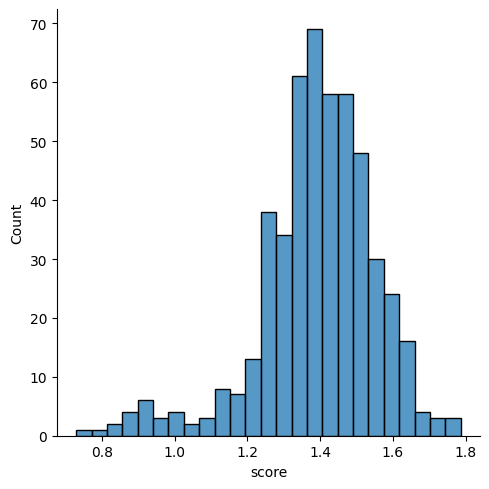

In [76]:
# Compile the results to a single dataframe
results_df = pd.concat(results_list)
print(len(results_df))

# Plot distribution of scores
sns.displot(x="score", data=results_df)


  0%|          | 0/600 [00:00<?, ?it/s]

/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


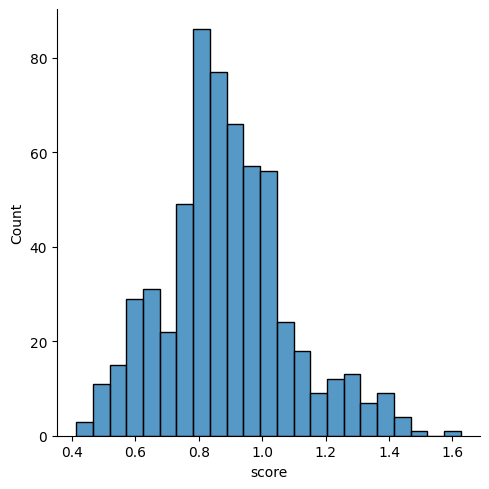

In [80]:
# Run Random selection search to compare with AL
random_df = df.sample(600).copy()
random_shape_results = oracle.get_values(random_df["SMILES"].values)
random_df = compile_ESP_results(random_df, random_shape_results)

# Plotting distribution of random selection
sns.displot(x="score", data=random_df)

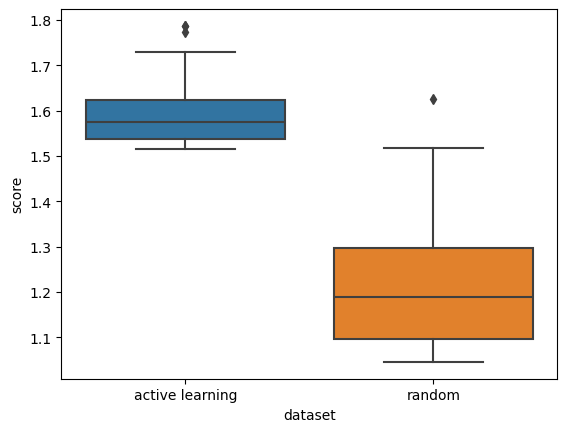

In [81]:
# Comparing AL and random slection scores
active_top_100_df = results_df.sort_values("score",ascending=False).head(100)
active_top_100_df['dataset'] = "active learning"
random_top_100_df = random_df.sort_values("score",ascending=False).head(100)
random_top_100_df['dataset'] = "random"
plot_df = pd.concat([active_top_100_df, random_top_100_df])
sns.boxplot(x="dataset",y="score",data=plot_df);

In [101]:


used_mols = pd.DataFrame(used, columns=["used_mols"])
used_mols

,used_mols
0,20812
1,50358
2,58996
3,15887
4,15314
...,...
595,50848
596,31115
597,33321
598,34010


Text(0.5, 0, 'Active Learning Cycle')

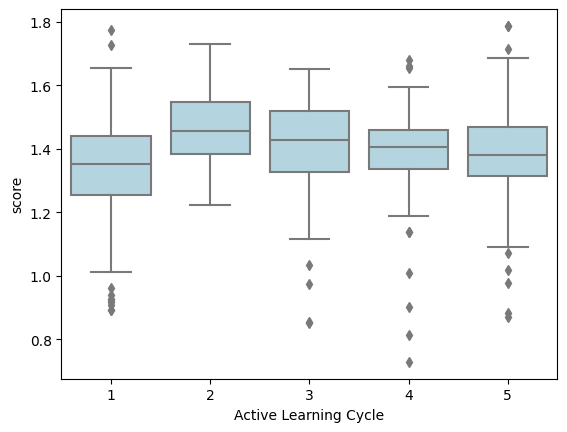

In [109]:
# Plot scores of molecules selected for each cycle
ax = sns.boxplot(x="cycles", y="score", data=results_df,color="lightblue")
ax.set_xlabel("Active Learning Cycle")

## Let's look at the highest scoring overlay and make sure our results make sense. We'll use [Py3DMol](https://pypi.org/project/py3Dmol/) to do this.

In [124]:
# Read in quer molecule
query_mol = Chem.MolFromMolFile("data/2chw_lig.sdf")

# Get the molecule with the higherst score from results file
db_mol = results_df.sort_values("score",ascending=False).shape_results.iloc[499].best_mol
db_mol = Chem.RemoveHs(db_mol)  

# Convert molecules to molblocks for py3DMol
query_mblock = Chem.MolToMolBlock(query_mol)
db_mblock = Chem.MolToMolBlock(db_mol)

# Create a 3D viewer
view = py3Dmol.view()

# Add query molecule and dbmol to viewer
view.addModel(query_mblock,'mol')
view.addModel(db_mblock,'mol')

# Colour molecules
view.setStyle({"model" : 0}, {"stick": {"colorscheme": "greenCarbon"}})
view.setStyle({"model" : 1}, {"stick": {"colorscheme": "magentaCarbon"}})


# Zoom in and show the molecules
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.